In [1]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command


from dotenv import load_dotenv
load_dotenv()

model = ChatOpenAI()

def agent_1(state: MessagesState) -> Command[Literal["agent_2", "agent_3", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(...)
    # route to one of the agents or exit based on the LLM's decision
    # if the LLM returns "__end__", the graph will finish execution
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

def agent_2(state: MessagesState) -> Command[Literal["agent_1", "agent_3", END]]:
    response = model.invoke(...)
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

def agent_3(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    ...
    return Command(
        goto=response["next_agent"],
        update={"messages": [response["content"]]},
    )

builder = StateGraph(MessagesState)
builder.add_node(agent_1)
builder.add_node(agent_2)
builder.add_node(agent_3)

builder.add_edge(START, "agent_1")
network = builder.compile()

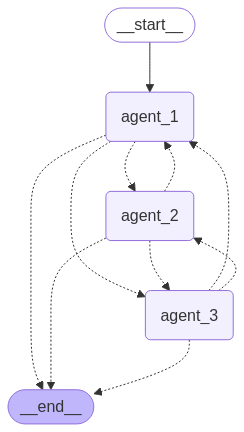

In [3]:
from IPython.display import Image
Image(network.get_graph().draw_mermaid_png())

In [4]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END

model = ChatOpenAI()

def supervisor(state: MessagesState) -> Command[Literal["agent_1", "agent_2", END]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # to determine which agent to call next. a common pattern is to call the model
    # with a structured output (e.g. force it to return an output with a "next_agent" field)
    response = model.invoke(...)
    # route to one of the agents or exit based on the supervisor's decision
    # if the supervisor returns "__end__", the graph will finish execution
    return Command(goto=response["next_agent"])

def agent_1(state: MessagesState) -> Command[Literal["supervisor"]]:
    # you can pass relevant parts of the state to the LLM (e.g., state["messages"])
    # and add any additional logic (different models, custom prompts, structured output, etc.)
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

def agent_2(state: MessagesState) -> Command[Literal["supervisor"]]:
    response = model.invoke(...)
    return Command(
        goto="supervisor",
        update={"messages": [response]},
    )

builder = StateGraph(MessagesState)
builder.add_node(supervisor)
builder.add_node(agent_1)
builder.add_node(agent_2)

builder.add_edge(START, "supervisor")

supervisor = builder.compile()

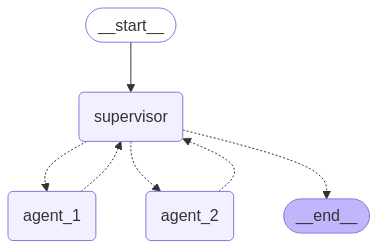

In [5]:
from IPython.display import Image
Image(supervisor.get_graph().draw_mermaid_png())

In [13]:
from typing_extensions import Literal
from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.types import Command

# model = ChatAnthropic(model="claude-3-5-sonnet-latest")
model = ChatOpenAI()


@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help."""
    # This tool is not returning anything: we're just using it
    # as a way for LLM to signal that it needs to hand off to another agent
    # (See the paragraph above)
    return


@tool
def transfer_to_addition_expert():
    """Ask addition agent for help."""
    return


def addition_expert(
    state: MessagesState,
) -> Command[Literal["multiplication_expert", "__end__"]]:
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication. "
        "Always do your portion of calculation before the handoff."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}


def multiplication_expert(
    state: MessagesState,
) -> Command[Literal["addition_expert", "__end__"]]:
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="addition_expert", update={"messages": [ai_msg, tool_msg]})

    return {"messages": [ai_msg]}

In [14]:
builder = StateGraph(MessagesState)
builder.add_node("addition_expert", addition_expert)
builder.add_node("multiplication_expert", multiplication_expert)
# we'll always start with the addition expert
builder.add_edge(START, "addition_expert")
graph = builder.compile()

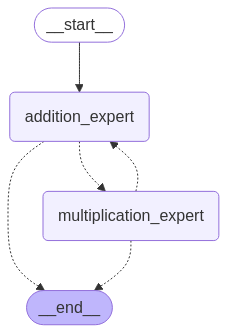

In [12]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [15]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [16]:
for chunk in graph.stream(
    {"messages": [("user", "what's (3 + 5) * 12")]},
):
    pretty_print_messages(chunk)

Update from node addition_expert:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_multiplication_expert (call_Dl2BOQykJ6Q113Xd8yuA4Bwl)
 Call ID: call_Dl2BOQykJ6Q113Xd8yuA4Bwl
  Args:
================================= Tool Message =================================

Successfully transferred


Update from node multiplication_expert:


================================== Ai Message ==================================

I have calculated the addition part of the expression. Now I will transfer you to the addition expert to help with the multiplication.
Tool Calls:
  transfer_to_addition_expert (call_XvCD9zF2YASs1ixKtOqG2ap0)
 Call ID: call_XvCD9zF2YASs1ixKtOqG2ap0
  Args:
================================= Tool Message =================================

Successfully transferred


Update from node addition_expert:


================================== Ai Message ==================================

I have successfully transferred you to

## How to build a multi-agent network

command

In [1]:
#1.Using a custom agent implementation
from dotenv import load_dotenv
load_dotenv()

True

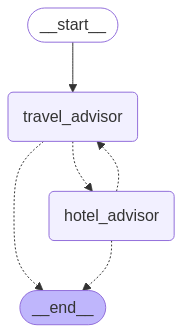

In [13]:
#Define agent nodes and graph

from typing_extensions import Literal

from langchain_core.messages import ToolMessage
from langchain_core.tools import tool
# from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.types import Command

from langchain_openai import ChatOpenAI

model = ChatOpenAI()
# model = ChatAnthropic(model="claude-3-5-sonnet-latest")


# Define a helper for each of the agent nodes to call


@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    # This tool is not returning anything: we're just using it
    # as a way for LLM to signal that it needs to hand off to another agent
    # (See the paragraph above)
    return


@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return


def travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}


def hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    # If there are tool calls, the LLM needs to hand off to another agent
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        # NOTE: it's important to insert a tool message here because LLM providers are expecting
        # all AI messages to be followed by a corresponding tool result message
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})

    # If the expert has an answer, return it directly to the user
    return {"messages": [ai_msg]}

#StateGraph
builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", travel_advisor)
builder.add_node("hotel_advisor", hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()

from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [ ]:
for chunk in graph.stream(
    {"messages": [("user", "i wanna go somewhere warm in the caribbean")]}
):
    pretty_print_messages(chunk)


Update from node travel_advisor:


==================================[1m Ai Message [0m==================================

I'd be happy to help you plan a Caribbean vacation! The Caribbean is perfect for warm weather getaways. Let me suggest some fantastic destinations:

1. Dominican Republic
- Known for beautiful beaches, all-inclusive resorts, and tropical climate
- Popular areas include Punta Cana and Puerto Plata
- Great mix of beaches, culture, and activities

2. Jamaica
- Famous for its laid-back atmosphere and beautiful beaches
- Popular spots include Montego Bay, Negril, and Ocho Rios
- Known for reggae music, delicious cuisine, and water sports

3. Bahamas
- Crystal clear waters and stunning beaches
- Perfect for island hopping
- Great for water activities and swimming with pigs at Pig Beach

4. Turks and Caicos
- Pristine beaches and luxury resorts
- Excellent for snorkeling and diving
- More peaceful and less crowded than some other Caribbean destinations

5. Aruba
- Known for constant sunny weather and minimal rainfall
- Beautiful white sand beaches
- Great shopping and dining options

Would you like me to provide more specific information about any of these destinations? Also, if you'd like hotel recommendations for any of these locations, I can transfer you to our hotel advisor for specific accommodation suggestions. Just let me know which destination interests you most!

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick one destination and give me hotel recommendations",
            )
        ]
    }
):
    pretty_print_messages(chunk)

Update from node travel_advisor:


==================================[1m Ai Message [0m==================================

[{'text': "I'll help you with a Caribbean destination recommendation! Given the vast number of beautiful Caribbean islands, I'll recommend one popular destination: the Dominican Republic, specifically Punta Cana. It offers pristine beaches, warm weather year-round, crystal-clear waters, and excellent resorts.\n\nLet me get some hotel recommendations for Punta Cana by consulting our hotel advisor.", 'type': 'text'}, {'id': 'toolu_01B9djUstpDKHVSy3o3rfzsG', 'input': {}, 'name': 'transfer_to_hotel_advisor', 'type': 'tool_use'}]
Tool Calls:
  transfer_to_hotel_advisor (toolu_01B9djUstpDKHVSy3o3rfzsG)
 Call ID: toolu_01B9djUstpDKHVSy3o3rfzsG
  Args:
=================================[1m Tool Message [0m=================================

Successfully transferred


Update from node hotel_advisor:


==================================[1m Ai Message [0m==================================

For Punta Cana, here are some top hotel recommendations:

1. Hyatt Zilara Cap Cana - Adults-only, all-inclusive luxury resort with pristine beachfront location, multiple pools, and upscale dining options.

2. Hard Rock Hotel & Casino Punta Cana - Perfect for entertainment lovers, featuring 13 pools, 9 restaurants, a casino, and extensive amenities.

3. Excellence Punta Cana - Adults-only, all-inclusive resort known for its romantic atmosphere and excellent service.

4. Secrets Cap Cana Resort & Spa - Sophisticated adults-only resort with beautiful swim-out suites and gourmet dining options.

5. The Reserve at Paradisus Palma Real - Family-friendly luxury resort with dedicated family concierge, kids' activities, and beautiful pools.

These resorts all offer:
- Direct beach access
- Multiple restaurants
- Swimming pools
- Spa facilities
- High-quality accommodations

Would you like more specific information about any of these hotels or would you prefer to explore hotels in a different Caribbean destination?

In [ ]:
multi-agent  network

many-to-mary  connections

## Task:build a team of travel assistant agents that can communicate with each other.
basic:create 2 agents:
1. travel_advisor
2. hotel_advisor 

hw:
Expand the travel assistant agents team and add more functions to offer a more comprehensive travel planning experience.
3.flight advisor
4.weather advisor
5.food recommendation

fully-connected network->every agent can talk to any other agent.

method: Using with a prebuilt ReAct agent or custom agent implementation



handoff  Command



In [2]:
##2. Using with a prebuilt ReAct agent---Create_React_agent

import random
from typing_extensions import Literal
from langchain_core.tools import tool
from dotenv import load_dotenv
load_dotenv()

@tool
def get_travel_recommendations():
    """Get recommendation for travel destinations"""
    return random.choice(["aruba", "turks and caicos"])


@tool
def get_hotel_recommendations(location: Literal["aruba", "turks and caicos"]):
    """Get hotel recommendations for a given destination."""
    return {
        "aruba": [
            "The Ritz-Carlton, Aruba (Palm Beach)"
            "Bucuti & Tara Beach Resort (Eagle Beach)"
        ],
        "turks and caicos": ["Grace Bay Club", "COMO Parrot Cay"],
    }[location]

In [3]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState
# Version: 0.3.5

def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

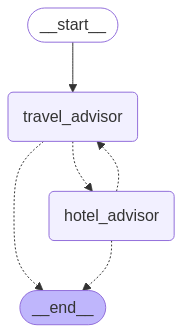

In [9]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command


# model = ChatAnthropic(model="claude-3-5-sonnet-latest")
from langchain_openai import ChatOpenAI

model = ChatOpenAI()


# Define travel advisor ReAct agent
travel_advisor_tools = [
    get_travel_recommendations,
    make_handoff_tool(agent_name="hotel_advisor"),
]
travel_advisor = create_react_agent(
    model,
    travel_advisor_tools,
    prompt=(
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "__end__"]]:
    # You can also add additional logic like changing the input to the agent / output from the agent, etc.
    # NOTE: we're invoking the ReAct agent with the full history of messages in the state
    return travel_advisor.invoke(state)


# Define hotel advisor ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="travel_advisor"),
]
hotel_advisor = create_react_agent(
    model,
    hotel_advisor_tools,
    prompt=(
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "__end__"]]:
    return hotel_advisor.invoke(state)


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", call_travel_advisor)
builder.add_node("hotel_advisor", call_hotel_advisor)
# we'll always start with a general travel advisor
builder.add_edge(START, "travel_advisor")

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            (
                "user",
                "i wanna go somewhere warm in the caribbean. pick one destination and give me hotel recommendations",
            )
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk)